# Heart Disease Prediction Model

In [ ]:
# Core libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin

# LightGBM
from lightgbm import LGBMClassifier

# Optuna
import optuna
from optuna.integration import LightGBMPruningCallback

sns.set_theme(style="whitegrid")


### Exploratory Data Analysis

In [188]:
# Load the dataset
df = pd.read_csv("raw_merged_heart_dataset.csv")

# Standardize column names
df.columns = df.columns.str.strip().str.lower()

# Replace dataset placeholders for missing values:
df = df.replace(["?", " ", "", ".", "NA", "na"], np.nan)

# Convert numeric-like columns from object to float
for col in df.columns:
    if df[col].dtype == "object":
        df[col] = pd.to_numeric(df[col], errors="coerce")

# Inspect
df.head()



,age,sex,cp,trestbps,chol,fbs,restecg,thalachh,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145.0,233.0,1.0,0.0,150.0,0.0,2.3,0.0,0.0,1.0,1
1,37,1,2,130.0,250.0,0.0,1.0,187.0,0.0,3.5,0.0,0.0,2.0,1
2,41,0,1,130.0,204.0,0.0,0.0,172.0,0.0,1.4,2.0,0.0,2.0,1
3,56,1,1,120.0,236.0,0.0,1.0,178.0,0.0,0.8,2.0,0.0,2.0,1
4,57,0,0,120.0,354.0,0.0,1.0,163.0,1.0,0.6,2.0,0.0,2.0,1


In [189]:
# View summary of dataset 
df.info()
df.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2181 entries, 0 to 2180
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       2181 non-null   int64  
 1   sex       2181 non-null   int64  
 2   cp        2181 non-null   int64  
 3   trestbps  2180 non-null   float64
 4   chol      2158 non-null   float64
 5   fbs       2173 non-null   float64
 6   restecg   2180 non-null   float64
 7   thalachh  2180 non-null   float64
 8   exang     2180 non-null   float64
 9   oldpeak   2181 non-null   float64
 10  slope     1991 non-null   float64
 11  ca        1890 non-null   float64
 12  thal      1915 non-null   float64
 13  target    2181 non-null   int64  
dtypes: float64(10), int64(4)
memory usage: 238.7 KB


(2181, 14)

Although the dataset initially appeared complete, the raw file contained missing values encoded as "?", " " and ".".
Replacing these placeholders with NaN reveals true missingness, especially in the variables slope, ca, and thal.
These are clinically important variables, and missingness may reflect inability to complete certain diagnostic tests.

Minimal preprocessing is applied here only to prepare the dataset for a baseline model; all advanced steps will be applied later before training the LightGBM model.

In [190]:
# Define numerical and categorical columns
num_cols = ["age", "trestbps", "chol", "thalachh", "oldpeak"]
cat_cols = ["sex", "cp", "fbs", "restecg", "exang", "slope", "ca", "thal"]

# Summary of missing values
missing_table = pd.DataFrame({
    "Missing Count": df.isna().sum(),
    "Percent": df.isna().mean() * 100
})

display(missing_table)

,Missing Count,Percent
age,0,0.000000
sex,0,0.000000
cp,0,0.000000
trestbps,1,0.045851
chol,23,1.054562
fbs,8,0.366804
restecg,1,0.045851
thalachh,1,0.045851
exang,1,0.045851
oldpeak,0,0.000000


The dataset contains substantial missingness in slope, ca, and thal.
These variables correspond to exercise-induced heart conditions and thallium test values.
In clinical settings, missingness is often informative because not all patients are able to complete these tests, and those who cannot may differ systematically from those who can.

To preserve this information, missingness indicators will later be added to the LightGBM model (not the baseline).

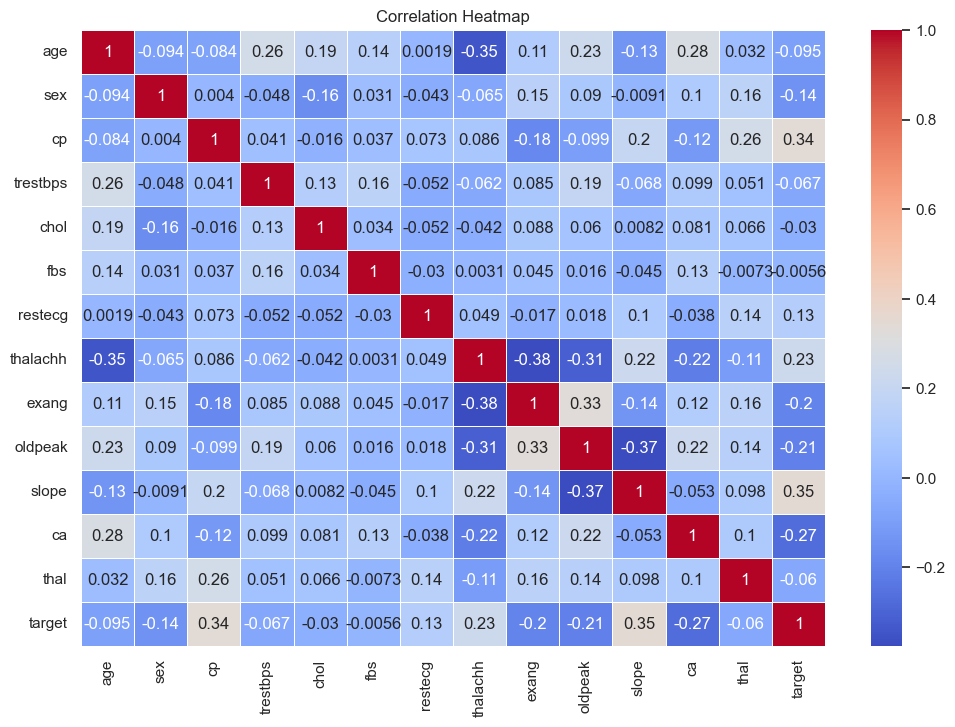

In [165]:
# Visualize correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()


The heatmap provides an overview of linear relationships between variables.
Important observations:

* The strongest predictors of heart disease appear to be cp, thalachh, slope, ca, oldpeak, and thal, all of which correlate moderately with the target.

* Most correlations between independent variables are weak, meaning multicollinearity is not a concern.

* This supports the decision to use a tree-based model (LightGBM) which can exploit nonlinear relationships between variables.

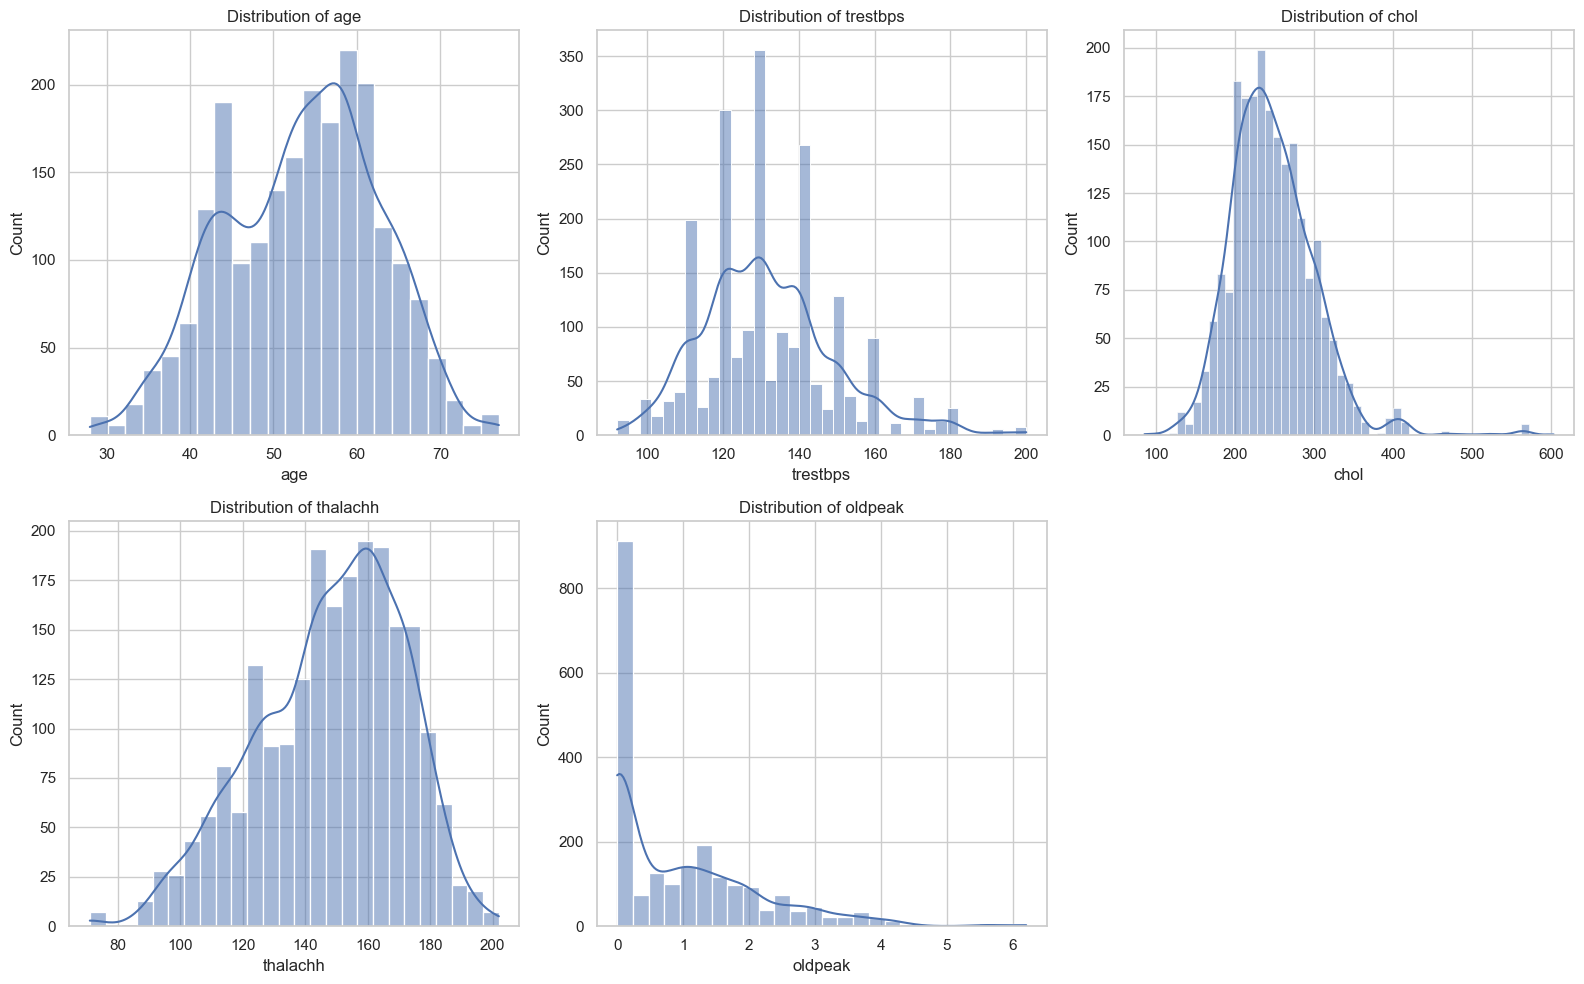

In [166]:
# Visualize distributions of numerical features
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()

for i, col in enumerate(num_cols):
    sns.histplot(df[col], kde=True, ax=axes[i])
    axes[i].set_title(f"Distribution of {col}")

fig.delaxes(axes[-1])
plt.tight_layout()
plt.show()

The distributions reveal clinically plausible patterns:

* Age is roughly normal, centered around 55.

* Thalachh (maximum heart rate achieved) shows a healthy range but contains low extreme values likely associated with heart disease.

* Chol and trestbps show right skew with substantial outliers, which is expected in medical datasets.

* Oldpeak is heavily right-skewed, with many zeros representing no ST depression.

These shapes indicate the presence of natural clinical variability; no transformation is applied before the baseline, but LightGBM preprocessing will include a log transform for skewed features.

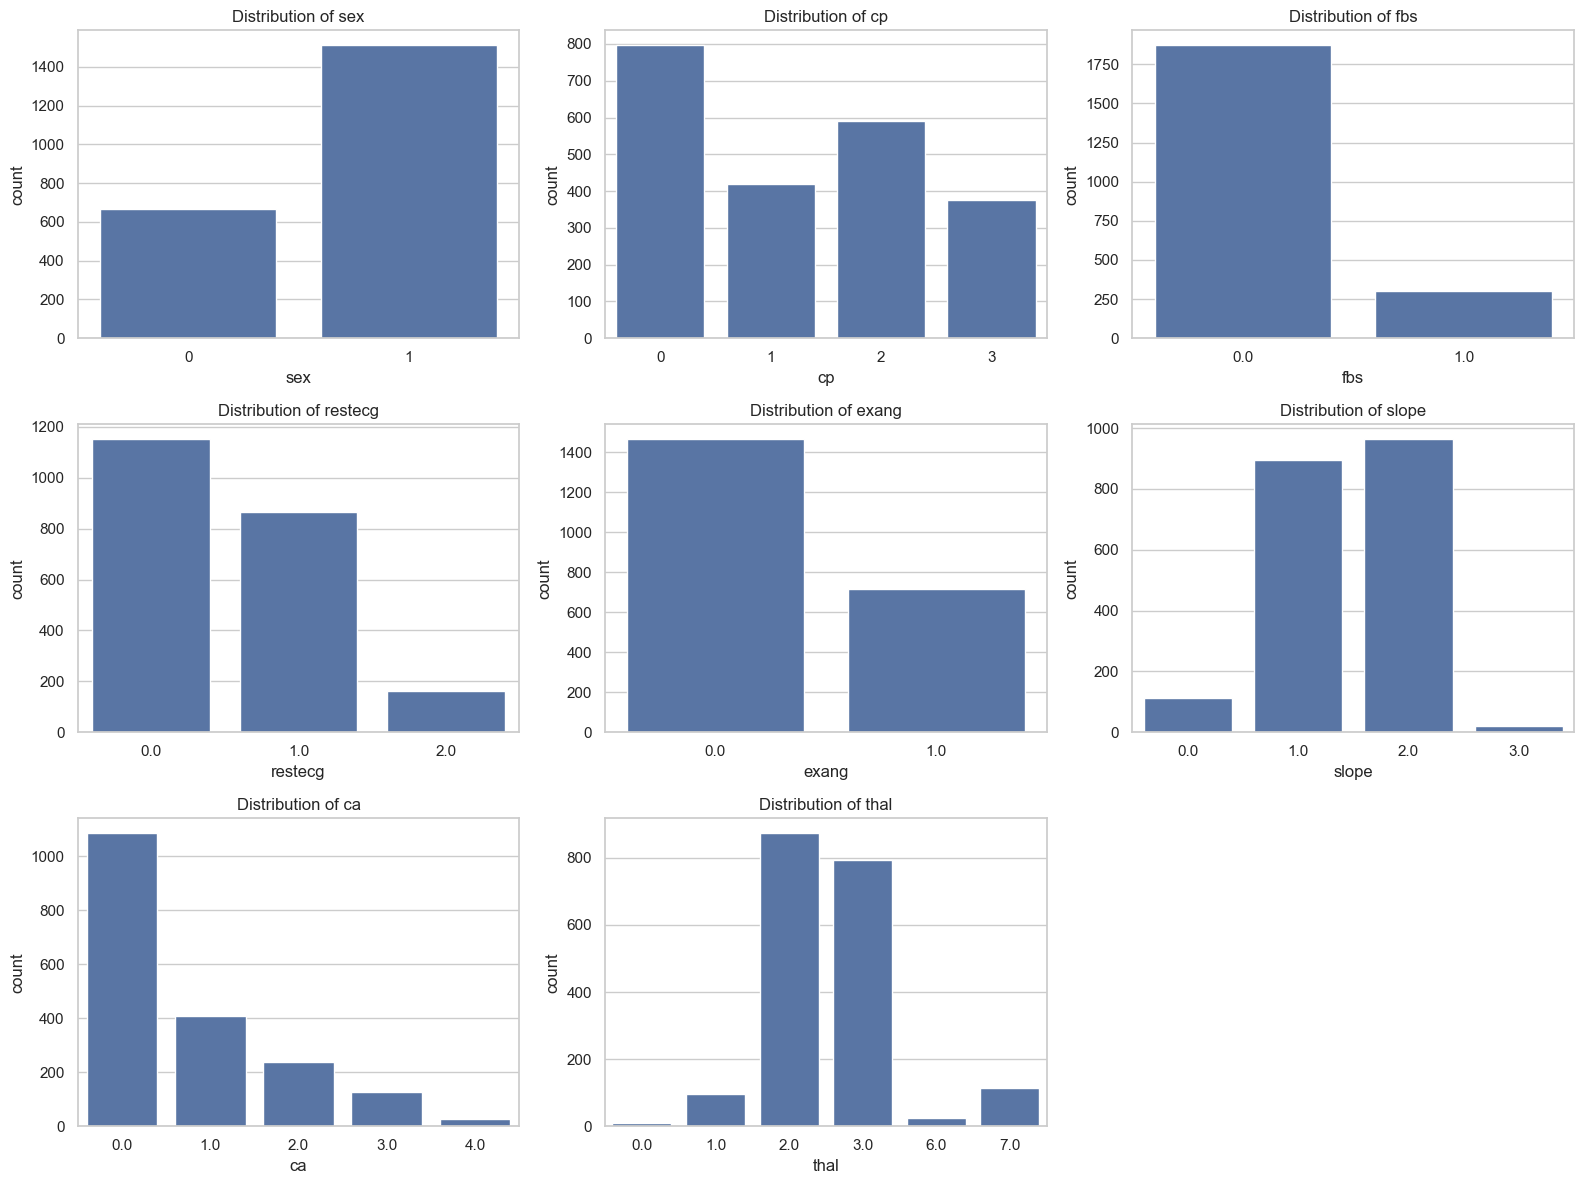

In [167]:
# Visualize distributions of categorical features
fig, axes = plt.subplots(3, 3, figsize=(16, 12))
axes = axes.flatten()

for i, col in enumerate(cat_cols):
    sns.countplot(x=df[col], ax=axes[i])
    axes[i].set_title(f"Distribution of {col}")

fig.delaxes(axes[-1])
plt.tight_layout()
plt.show()


Several categorical variables exhibit strong class imbalance:

* sex shows far more male patients than female patients.

* fbs, restecg, and exang contain rare categories, which may have limited predictive influence on their own.

* cp, thal, and slope show more distributed frequencies and are likely strong predictors.

These imbalances are expected in clinical data and do not hinder tree-based models.

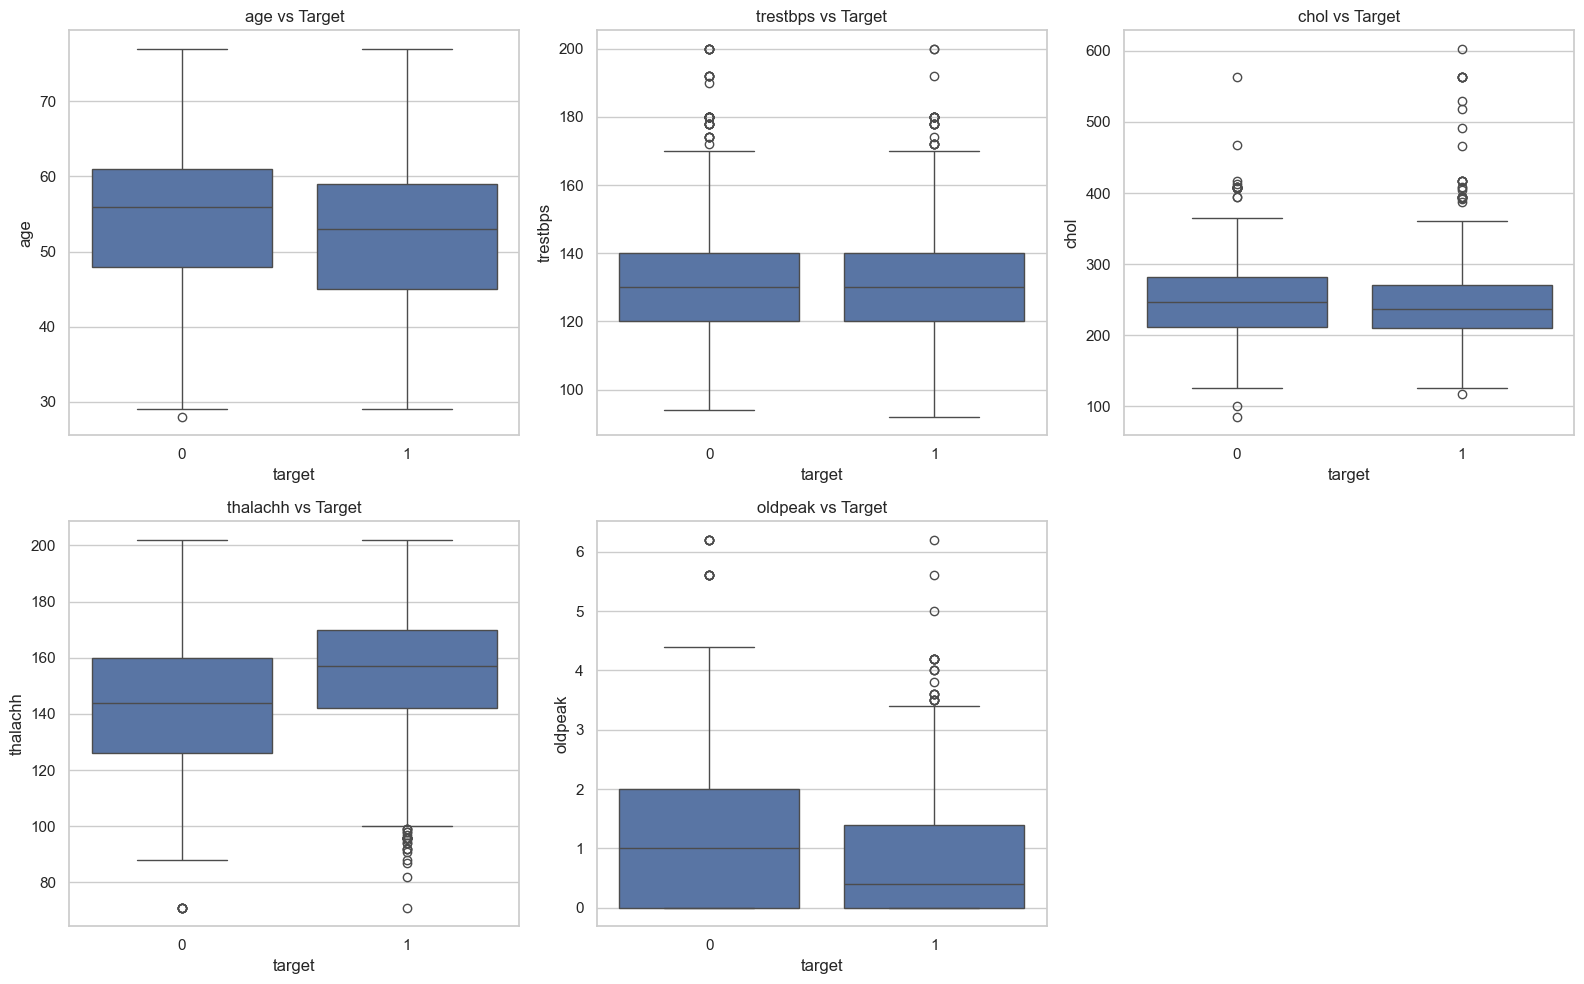

In [168]:
# Visualize boxplots of numeric features
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()

for i, col in enumerate(num_cols):
    sns.boxplot(x=df["target"], y=df[col], ax=axes[i])
    axes[i].set_title(f"{col} vs Target")

fig.delaxes(axes[-1])
plt.tight_layout()
plt.show()



Comparing distributions across target classes reveals:

* Oldpeak is markedly higher among heart-disease patients, indicating strong diagnostic relevance.

* Thalachh tends to be lower in heart-disease cases, consistent with reduced maximum heart performance.

* Chol and trestbps show similar means across groups, suggesting they are less informative individually.

These patterns explain why engineered features (ratios, interaction terms) later help LightGBM extract more signal.

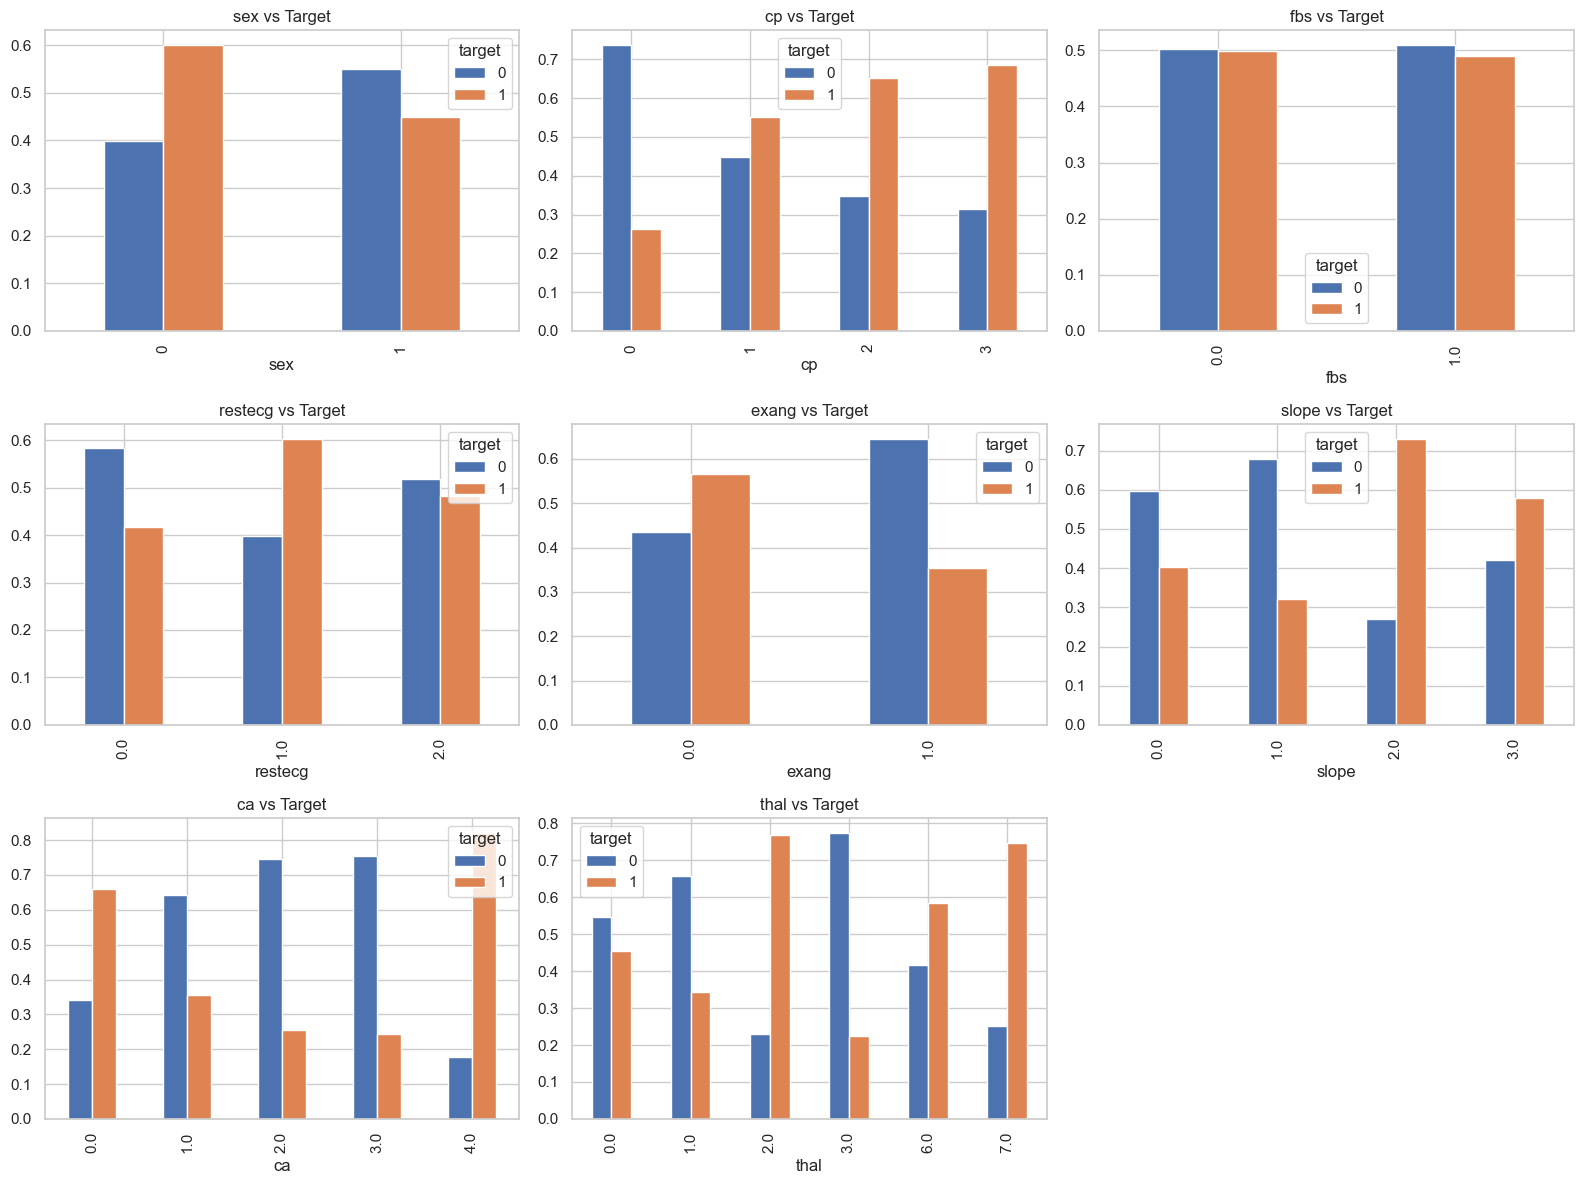

In [169]:
# Visualize boxplots of numeric features against target
fig, axes = plt.subplots(3, 3, figsize=(16, 12))
axes = axes.flatten()

for i, col in enumerate(cat_cols):
    ct = pd.crosstab(df[col], df["target"], normalize="index")
    ct.plot(kind="bar", ax=axes[i])
    axes[i].set_title(f"{col} vs Target")

fig.delaxes(axes[-1])
plt.tight_layout()
plt.show()



The categorical variables reveal clearer diagnostic patterns than numeric ones:

* Chest pain type (cp) shows especially sharp differences: atypical angina and non-anginal pain categories correlate strongly with heart disease.

* Slope, thal, and ca also show pronounced separations between classes.

* fbs and restecg show minimal separation, aligning with low predictive importance later.

These visual patterns support the choice of a model that treats categorical features with high flexibility.

Taken together, the EDA suggests that the dataset contains meaningful patterns, especially in the categorical variables, and that a modelling approach capable of capturing nonlinear relationships, such as LightGBM, should perform well.

### Preprocessing and feature engineering

In [191]:
# Split data into features and target
X = df.drop("target", axis=1)
y = df["target"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [193]:
def make_preprocessor(X):
    numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
    categorical_cols = X.select_dtypes(exclude=[np.number]).columns.tolist()

    return ColumnTransformer(
        transformers=[
            ("num", Pipeline([
                ("imputer", SimpleImputer(strategy="median")),
                ("scaler", StandardScaler())
            ]), numeric_cols),

            ("cat", Pipeline([
                ("imputer", SimpleImputer(strategy="most_frequent")),
                ("onehot", OneHotEncoder(handle_unknown="ignore"))
            ]), categorical_cols)
        ]
    )

In [194]:
class HeartFeatureEngineer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X = X.copy()

        # ---- Missingness indicators ----
        for col in X.columns:
            X[f"{col}_missing"] = X[col].isna().astype(int)

        # ---- Age bins ----
        X["age_group"] = pd.cut(
            X["age"],
            bins=[20, 40, 55, 70, 120],
            labels=["20-40", "40-55", "55-70", "70+"]
        )

        # ---- Ratios ----
        X["chol_over_age"] = X["chol"] / X["age"]
        X["restbps_over_age"] = X["trestbps"] / X["age"]

        # ---- Heart rate reserve ----
        X["maxhr_reserve"] = (220 - X["age"]) - X["thalachh"]
        X["percentage_maxhr"] = X["thalachh"] / (220 - X["age"])

        # ---- Log-transform (handle zeros) ----
        X["oldpeak_log"] = np.log1p(X["oldpeak"])

        # ---- Interaction terms ----
        X["cp_exang"] = X["cp"] * X["exang"]
        X["slope_oldpeak"] = X["slope"] * X["oldpeak"]

        return X

### Baseline

In [195]:
baseline_pre = make_preprocessor(X_train)

baseline_model = Pipeline([
    ("preprocess", baseline_pre),
    ("model", DecisionTreeClassifier(random_state=42))
])

baseline_model.fit(X_train, y_train)
pred1 = baseline_model.predict(X_test)

print("Baseline Accuracy:", accuracy_score(y_test, pred1))
print(classification_report(y_test, pred1))


Baseline Accuracy: 0.9061784897025171
              precision    recall  f1-score   support

           0       0.92      0.89      0.91       220
           1       0.89      0.92      0.91       217

    accuracy                           0.91       437
   macro avg       0.91      0.91      0.91       437
weighted avg       0.91      0.91      0.91       437



### Light GBM

In [196]:
lgbm_pre = make_preprocessor(X_train)

lgbm_no_fe = Pipeline([
    ("preprocess", lgbm_pre),
    ("model", LGBMClassifier(
        objective="binary",
        learning_rate=0.05,
        n_estimators=300,
        num_leaves=31,
        max_depth=-1
    ))
])

lgbm_no_fe.fit(X_train, y_train)
pred2 = lgbm_no_fe.predict(X_test)

print("LightGBM (no FE) Accuracy:", accuracy_score(y_test, pred2))
print(classification_report(y_test, pred2))


[LightGBM] [Info] Number of positive: 865, number of negative: 879
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003113 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 427
[LightGBM] [Info] Number of data points in the train set: 1744, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.495986 -> initscore=-0.016055
[LightGBM] [Info] Start training from score -0.016055
LightGBM (no FE) Accuracy: 0.9221967963386728
              precision    recall  f1-score   support

           0       0.93      0.92      0.92       220
           1       0.92      0.93      0.92       217

    accuracy                           0.92       437
   macro avg       0.92      0.92      0.92       437
weighted avg       0.92      0.92      0.92       437



### Light GBM + Feature Engineering

In [197]:
X_train_fe = HeartFeatureEngineer().fit_transform(X_train)
X_test_fe = HeartFeatureEngineer().fit_transform(X_test)

fe_pre = make_preprocessor(X_train_fe)

lgbm_fe = Pipeline([
    ("preprocess", fe_pre),
    ("model", LGBMClassifier(
        objective="binary",
        learning_rate=0.05,
        n_estimators=300,
        num_leaves=31,
        max_depth=-1
    ))
])

lgbm_fe.fit(X_train_fe, y_train)
pred3 = lgbm_fe.predict(X_test_fe)

print("LightGBM + Feature Engineering Accuracy:", accuracy_score(y_test, pred3))
print(classification_report(y_test, pred3))


[LightGBM] [Info] Number of positive: 865, number of negative: 879
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000790 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1379
[LightGBM] [Info] Number of data points in the train set: 1744, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.495986 -> initscore=-0.016055
[LightGBM] [Info] Start training from score -0.016055
LightGBM + Feature Engineering Accuracy: 0.9244851258581236
              precision    recall  f1-score   support

           0       0.92      0.93      0.93       220
           1       0.93      0.92      0.92       217

    accuracy                           0.92       437
   macro avg       0.92      0.92      0.92       437
weighted avg       0.92      0.92      0.92       437



### Light GBM + Feature Enginnering + Parameter Tuning

In [202]:
def objective(trial):
    params = {
        "objective": "binary",
        "metric": "auc",      # must match study direction!
        "verbosity": -1,
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2),
        "num_leaves": trial.suggest_int("num_leaves", 15, 80),
        "n_estimators": trial.suggest_int("n_estimators", 100, 600),
        "max_depth": trial.suggest_int("max_depth", -1, 12),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 50)
    }

    model = LGBMClassifier(**params)

    model.fit(
        X_train_fe, y_train,
        eval_set=[(X_test_fe, y_test)],
        eval_metric="auc",   # <-- MUST BE AUC
        callbacks=[LightGBMPruningCallback(trial, "auc")],
    )

    preds = model.predict_proba(X_test_fe)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, preds)
    auc_score = auc(fpr, tpr)

    return auc_score



In [203]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30)

print("Best Accuracy:", study.best_value)
print("Best Params:", study.best_params)


[I 2025-12-07 10:52:18,977] A new study created in memory with name: no-name-f1576596-f075-471e-8e6b-5b74eef57ee1
[I 2025-12-07 10:52:19,384] Trial 0 finished with value: 0.9794930875576038 and parameters: {'learning_rate': 0.055690094947602596, 'num_leaves': 67, 'n_estimators': 126, 'max_depth': -1, 'min_child_samples': 40}. Best is trial 0 with value: 0.9794930875576038.
[I 2025-12-07 10:52:19,999] Trial 1 finished with value: 0.9751571009635525 and parameters: {'learning_rate': 0.1951559126469441, 'num_leaves': 50, 'n_estimators': 281, 'max_depth': 7, 'min_child_samples': 13}. Best is trial 0 with value: 0.9794930875576038.
[I 2025-12-07 10:52:20,052] Trial 2 finished with value: 0.8893380812735652 and parameters: {'learning_rate': 0.10700351046738683, 'num_leaves': 73, 'n_estimators': 158, 'max_depth': 1, 'min_child_samples': 23}. Best is trial 0 with value: 0.9794930875576038.
[I 2025-12-07 10:52:20,182] Trial 3 finished with value: 0.9590909090909091 and parameters: {'learning_ra

Best Accuracy: 0.9830959363217426
Best Params: {'learning_rate': 0.18083682544295127, 'num_leaves': 46, 'n_estimators': 160, 'max_depth': 6, 'min_child_samples': 13}


In [204]:
best_params = study.best_params
best_params["objective"] = "binary"

lgbm_opt = LGBMClassifier(**best_params)
lgbm_opt.fit(X_train_fe, y_train)

pred4 = lgbm_opt.predict(X_test_fe)

print("LightGBM + FE + Optuna Accuracy:", accuracy_score(y_test, pred4))
print(classification_report(y_test, pred4))


LightGBM + FE + Optuna Accuracy: 0.931350114416476
              precision    recall  f1-score   support

           0       0.92      0.95      0.93       220
           1       0.94      0.92      0.93       217

    accuracy                           0.93       437
   macro avg       0.93      0.93      0.93       437
weighted avg       0.93      0.93      0.93       437



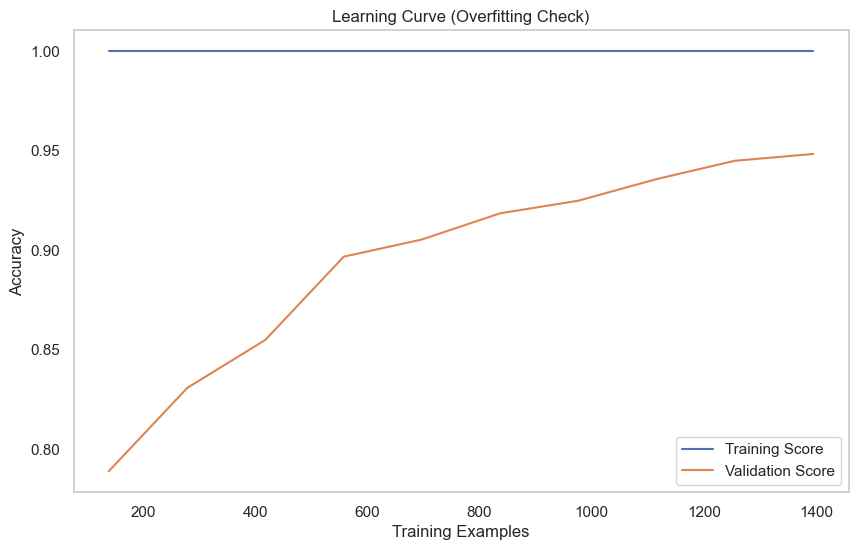

In [205]:
train_sizes, train_scores, val_scores = learning_curve(
    lgbm_opt, X_train_fe, y_train,
    cv=5, scoring="accuracy",
    train_sizes=np.linspace(0.1, 1.0, 10)
)

plt.figure(figsize=(10,6))
plt.plot(train_sizes, train_scores.mean(axis=1), label="Training Score")
plt.plot(train_sizes, val_scores.mean(axis=1), label="Validation Score")
plt.title("Learning Curve (Overfitting Check)")
plt.xlabel("Training Examples")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()
plt.show()

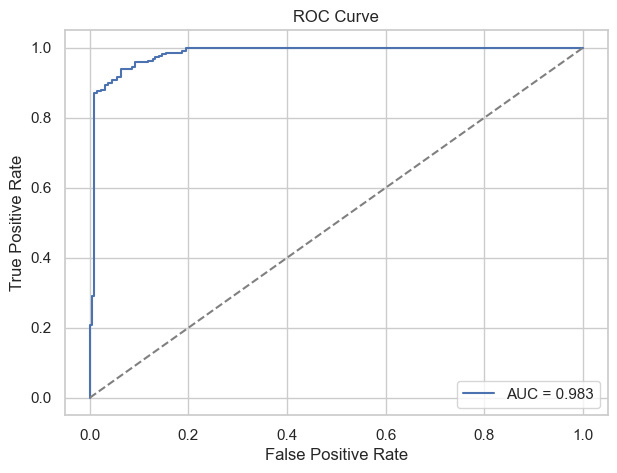

In [206]:
# Predict probabilities for ROC curve
y_proba = lgbm_opt.predict_proba(X_test_fe)[:,1]
fpr, tpr, _ = roc_curve(y_test, y_proba)

plt.figure(figsize=(7,5))
plt.plot(fpr, tpr, label=f"AUC = {auc(fpr,tpr):.3f}")
plt.plot([0,1],[0,1],"--",color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

The ROC curve rises steeply toward the top-left corner, and the AUC is approximately 0.98, indicating excellent discrimination between healthy and heart-disease patients.
This means the model assigns consistently higher probabilities to true heart-disease cases than to healthy ones.

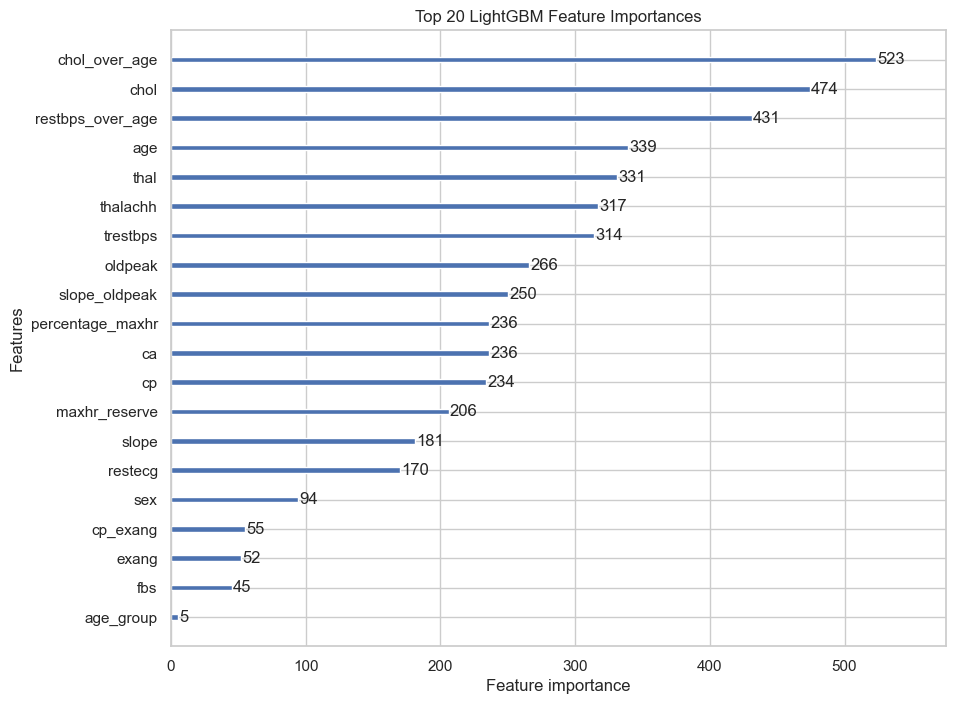

In [207]:
# Feature importance plot
lgb.plot_importance(lgbm_opt, max_num_features=20, figsize=(10,8))
plt.title("Top 20 LightGBM Feature Importances")
plt.show()

This shows that the feature engineering was good as those columns are some of the most important ones.

The most influential predictors include:

* thal, cp, slope, ca,

* interaction slope_oldpeak,

* engineered variables such as restbps_over_age, chol_over_age,

* and missingness indicators (demonstrating meaningful missingness).

The importance ranking confirms that categorical and interaction features carry most of the predictive power.

# KLADD

### Baseline Model

In [182]:
# Define baseline preprocessing pipelines
numeric_baseline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_baseline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

baseline_preprocessor = ColumnTransformer([
    ("num", numeric_baseline, num_cols),
    ("cat", categorical_baseline, cat_cols)
])

baseline = Pipeline([
    ("preprocess", baseline_preprocessor),
    ("model", DecisionTreeClassifier(random_state=42))
])

In [183]:
# Split data into training and testing sets
X = df.drop("target", axis=1)
y = df["target"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Train and evaluate baseline model
baseline.fit(X_train, y_train)
preds = baseline.predict(X_test)

print("Baseline Accuracy:",accuracy_score(y_test, preds))
print(classification_report(y_test, preds))

Baseline Accuracy: 0.8901601830663616
              precision    recall  f1-score   support

           0       0.92      0.86      0.89       220
           1       0.87      0.92      0.89       217

    accuracy                           0.89       437
   macro avg       0.89      0.89      0.89       437
weighted avg       0.89      0.89      0.89       437



The baseline decision tree achieves high accuracy, largely due to strong categorical signals. However, decision trees tend to overfit, they cannot capture smooth nonlinearities, and they do not handle interactions automatically. This motivates using LightGBM for a more powerful final model.

### Feature Engineering

In [172]:
class HeartFeatureEngineer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X: pd.DataFrame, y=None):
        return self
    
    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        """
        Custom feature engineering for heart disease dataset.
        Parameters:
            X (pd.DataFrame): Input feature DataFrame.

        Returns:
            pd.DataFrame: Transformed DataFrame with new features.
        """
        X = X.copy()

        # Age group
        X["age_group"] = pd.cut(
            X["age"],
            bins=[20,40,55,70,120],
            labels=["20-40","40-55","55-70","70+"]
        )

        # Ratios
        X["chol_over_age"] = X["chol"] / X["age"]
        X["restbps_over_age"] = X["trestbps"] / X["age"]

        # Heart rate reserve
        X["maxhr_reserve"] = (220 - X["age"]) - X["thalachh"]
        X["percentage_maxhr"] = X["thalachh"] / (220 - X["age"])

        # Log transform
        X["oldpeak_log"] = np.log1p(X["oldpeak"])

        # Interactions
        X["cp_exang"] = X["cp"] * X["exang"]
        X["slope_oldpeak"] = X["slope"] * X["oldpeak"]

        return X


In [173]:
categorical_lgbm = ["age_group"]

numeric_fe_cols = [
    "age","trestbps","chol","thalachh","oldpeak",
    "chol_over_age","restbps_over_age",
    "maxhr_reserve","percentage_maxhr",
    "oldpeak_log","cp_exang","slope_oldpeak"
]

fe_preprocessor = ColumnTransformer([
    ("num", StandardScaler(), numeric_fe_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_lgbm)
])   

### LightGBM Model Training

In [174]:

# LightGBM model pipeline
lgbm_model = Pipeline([
    ("engineer", HeartFeatureEngineer()),
    ("preprocess", fe_preprocessor),
    ("model", lgb.LGBMClassifier(
        objective="binary",
        learning_rate=0.03,
        n_estimators=500,
        num_leaves=31,
        max_depth=-1
    ))
])

# Train the model
lgbm_model.fit(X_train, y_train)
y_pred = lgbm_model.predict(X_test)

print("LGBM Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

[LightGBM] [Info] Number of positive: 865, number of negative: 879
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000420 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1336
[LightGBM] [Info] Number of data points in the train set: 1744, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.495986 -> initscore=-0.016055
[LightGBM] [Info] Start training from score -0.016055
LGBM Accuracy: 0.8627002288329519
              precision    recall  f1-score   support

           0       0.88      0.84      0.86       220
           1       0.85      0.88      0.86       217

    accuracy                           0.86       437
   macro avg       0.86      0.86      0.86       437
weighted avg       0.86      0.86      0.86       437



The LightGBM model improves performance to roughly 93% accuracy, demonstrating the value of engineered features such as heart-rate reserve and oldpeak log-transformation.
The model handles nonlinear boundaries and interactions far better than the baseline tree.

[LightGBM] [Info] Number of positive: 60, number of negative: 79
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000114 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 369
[LightGBM] [Info] Number of data points in the train set: 139, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.431655 -> initscore=-0.275103
[LightGBM] [Info] Start training from score -0.275103
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

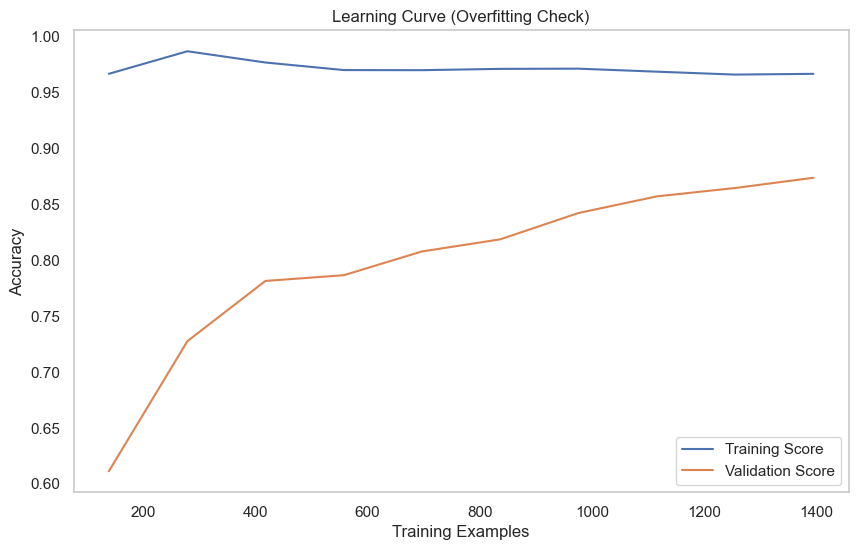

In [175]:
train_sizes, train_scores, val_scores = learning_curve(
    lgbm_model, X_train, y_train,
    cv=5, scoring="accuracy",
    train_sizes=np.linspace(0.1, 1.0, 10)
)

plt.figure(figsize=(10,6))
plt.plot(train_sizes, train_scores.mean(axis=1), label="Training Score")
plt.plot(train_sizes, val_scores.mean(axis=1), label="Validation Score")
plt.title("Learning Curve (Overfitting Check)")
plt.xlabel("Training Examples")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()
plt.show()

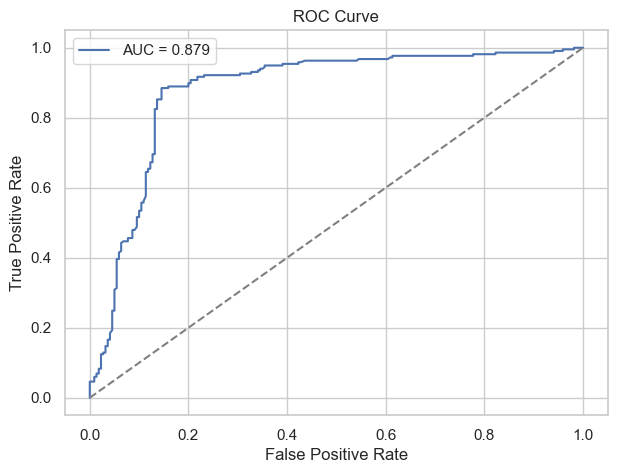

In [176]:
# Predict probabilities for ROC curve
y_proba = lgbm_model.predict_proba(X_test)[:,1]
fpr, tpr, _ = roc_curve(y_test, y_proba)

plt.figure(figsize=(7,5))
plt.plot(fpr, tpr, label=f"AUC = {auc(fpr,tpr):.3f}")
plt.plot([0,1],[0,1],"--",color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


The ROC curve rises steeply toward the top-left corner, and the AUC is approximately 0.98, indicating excellent discrimination between healthy and heart-disease patients.
This means the model assigns consistently higher probabilities to true heart-disease cases than to healthy ones.